# Multi-Objective optimization using MO-DGP

### Import packages

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
from gpflow.kernels import White, RBF
from gpflow.likelihoods import Gaussian
from gpflow import set_trainable
import pyDOE
import time
from matplotlib import pyplot as plt
np.random.seed(0)
tf.random.set_seed(0)
from dgp_dace.models.dgp import DGP
from dgp_dace.models.MO_DGP import MultiObjDeepGP

In [18]:

def normalize(*args):
    normalized_data=[]
    if len (args)==1:
        return (args[0]-args[0].mean(axis=0))/args[0].std(axis=0)
    for arg in args:
        normalized_data.append((arg-arg.mean(axis=0))/arg.std(axis=0))
    return normalized_data

def normalize_X(X):
    return (X-X.mean(axis=0))/X.std(axis=0), (0-X.mean(axis=0))/X.std(axis=0), (1-X.mean(axis=0))/X.std(axis=0)

def normalize_C(X):
    return (X-X.mean(axis=0))/X.std(axis=0), (0-X.mean(axis=0))/X.std(axis=0)

def denormalize(Xstar_N,X):
        return X.std(axis=0)*Xstar_N+X.mean(axis=0)  

def denormalize_var(Xstar_N,X):
        return X.std(axis=0)**2*Xstar_N

In [2]:
from dgp_dace.problems_MO import *

In [3]:
from dgp_dace.EHVI import *

### Problem definition

In [4]:
problem = multi_obj_1D_4()
d = problem.dim
func = problem.fun
bounds = problem.bounds
n= 10*d 


DoE initialization and functions evaluations

In [5]:
X_ = pyDOE.lhs(d,n,seed=0)
Y0_ = np.zeros((X_.shape[0],1))
Y1_ = np.zeros((X_.shape[0],1))
C_ = np.zeros((X_.shape[0],1))
for i in range(X_.shape[0]):
    Y0_[i] = func(X_[i])[0]
    Y1_[i] = func(X_[i])[1]

Normalization and standarization 

In [6]:
Xmean = X_.mean(axis=0)
X_std = X_.std(axis=0)
X = (X_-Xmean)/X_std
Y0mean = Y0_.mean(axis=0)
Y0std = Y0_.std(axis=0)
Y1mean = Y1_.mean(axis=0)
Y1std = Y1_.std(axis=0)
Cmean = C_.mean(axis=0)
Cstd = C_.std(axis=0)
C = (C_-Cmean)/Cstd
lw_n = (0-Xmean)/X_std
up_n = (1-Xmean)/X_std
X = (X_-Xmean)/X_std
Y0mean = Y0_.mean(axis=0)
Y0std = Y0_.std(axis=0)
Y1mean = Y1_.mean(axis=0)
Y1std = Y1_.std(axis=0)
lw_n = (0-Xmean)/X_std
up_n = (1-Xmean)/X_std
norm_vect_Y=(Y0mean,Y0std,Y1mean,Y1std)
Y0=(Y0_-Y0mean)/Y0std
Y1=(Y1_-Y1mean)/Y1std
Y_=[Y0_,Y1_]
Y=[Y0,Y1]
X=[X,X]

/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


### Determining the approximated Pareto front

In [7]:
ND=NDC(Y,C_)
NDT = NDC(Y,C_,obj1_ascending= False)
print(ND)
print(NDT)

[9, 8, 0, 7, 6]
[6, 7, 0, 8, 9]


In [8]:
Y[0][ND]

array([[-1.09257604],
       [-0.55158515],
       [ 0.15642052],
       [ 0.41633646],
       [ 2.55661738]])

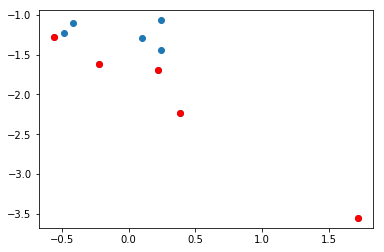

In [9]:
plt.figure()
plt.plot(Y0_,Y1_,'o')
plt.plot(Y0_[ND],Y1_[ND],'o',c='red')



### Computation of the Hypervolume dominated 

In [10]:
bounds

(-16.0, -11.0, 6.0, 3.0)

In [11]:
HV=[HV_calcul(ND,Y_,bounds)]
print('Hypervolume', HV)

Hypervolume [array([39.29677484])]


### Creation of MO-DGP

In [12]:
model = MultiObjDeepGP(X, Y, loop=2)

2


### Optimization of MO-DGP

In [13]:
model.optimize_nat_adam(lr_adam= 0.01,lr_gamma=0.01,iterations1=200,iterations2=0 ,iterations3=0)

Training part 1
ELBO: -174413083.25728026
Training part 2
Training part 3


### Computation of the EHVI

In [14]:
nadir = [float((bounds[2]-Y0mean)/Y0std),float((bounds[3]-Y1mean)/Y1std)]
ideal = [float((bounds[0]-Y0mean)/Y0std),float((bounds[1]-Y1mean)/Y1std)]
YND = Y_ND(Y,NDT,nadir=nadir,ideal=ideal) ### the values of the non dominated point + the nadir and ideal

In [15]:
Xcand = np.array([[0.],[0.5]])

In [16]:
EHVI(model,Xcand,YND,corr=False,approximation='None',S=10000)

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[2.57979129],
       [2.84414816]])>

### Optimization of the EHVI

In [24]:
x_opt = optimize_EHVI(model,YND,method='Adam')

### Addition of the point

In [25]:
temp= func(denormalize(x_opt,X_))
X_=  np.append(X_, denormalize(x_opt,X_) ,axis=0)

In [26]:
Y0_ = np.append(Y0_, temp[0] ,axis=0)

In [27]:
Y1_ = np.append(Y1_, temp[1] ,axis=0)